# Imports

In [1]:
import os
from datetime import timedelta
from logging import INFO, basicConfig, info
from time import time

from numpy import argmax
from numpy.random import seed as npseed
from sklearn.model_selection import train_test_split as split
from torch import device as Device
from torch.backends.mps import is_available as mps_available
from torch.cuda import is_available as cuda_available
from torch.optim import Adam
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

# from segmentation_models_pytorch import Unet

# from src.models.vitnet import VitNet

from src.models.unet import Unet
from src.utils.dataset import ForestDataset
from src.utils.loss import loss
from src.utils.models import evaluation, load, save, training
from src.utils.plots import plot_image_and_prediction
from src.utils.predictions import predict_patch, predict_image
from src.utils.preprocessing import Preprocessor
from src.utils.sampling import compute_sampling_weights

# Global parameters

In [2]:
patch_size = 256
img_dir = "data/images"
log_dir = "logs"
model_dir = "models"
patch_dir = f"data/patches/{patch_size}"
patches_file = f"data/patches/{patch_size}/info.fth"
gedi_file = "data/gedi/gedi_complete.fth"
seed = 42
batch_size = 8
num_workers = 6
learning_rate = 1e-4
epochs = 2
is_training = True
bins = list(range(0, 55, 5))
device = Device("cuda" if cuda_available() else "mps" if mps_available() else "cpu")

npseed(seed)
basicConfig(level=INFO)

info(f"Using {device} device")

INFO:root:Using mps device


# Preprocess labels and patches

In [3]:
# Create preprocessor
preprocessor = Preprocessor(patches_file, img_dir, patch_dir, gedi_file, patch_size)

preprocessor.run()

# Extract patches
labels = preprocessor.gedi.rh98
patches = preprocessor.patches

info(f"Total number of patches: {len(patches)}")

INFO:root:Starting preprocessing...
INFO:root:Directories validated.
INFO:root:Images loaded.
INFO:root:Number of images: 48
INFO:root:GEDI data loaded.
INFO:root:Loaded existing patch info file. Skipping image processing.
INFO:root:Number of patches: 9234
INFO:root:Number of labels: 629074
INFO:root:Total number of patches: 9234


<Axes: >

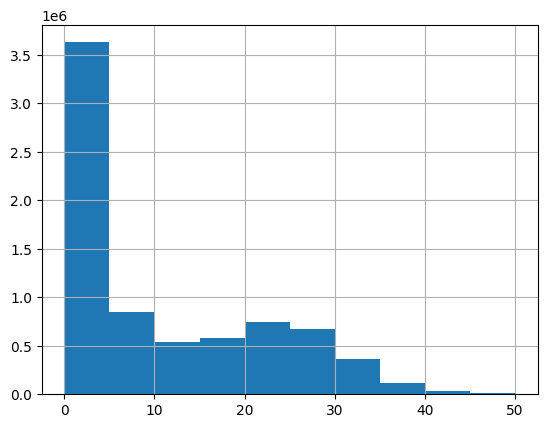

In [4]:
labels.hist(bins=bins)

## Create datasets & dataloader

In [5]:
# Create stratification
stratify = patches.bins.apply(argmax)

# Split patches
train, rest = split(patches, test_size=0.3, random_state=seed, stratify=stratify)

stratify = stratify[patches.index.isin(rest.index)]

val, test = split(rest, test_size=0.5, random_state=seed, stratify=stratify)

# Create datasets
traindata = ForestDataset(train, patch_dir)
valdata = ForestDataset(val, patch_dir)
testdata = ForestDataset(test, patch_dir)

# Create weighted sampler
weights = compute_sampling_weights(train, labels, bins)
sampler = WeightedRandomSampler(weights, len(train))

# Create dataloaders
trainloader = DataLoader(traindata, batch_size, False, sampler, num_workers=num_workers)
valloader = DataLoader(valdata, batch_size, False, num_workers=num_workers)
testloader = DataLoader(testdata, batch_size, False, num_workers=num_workers)

# U-Net

## Create model

In [6]:
# model = VitNet().to(device)

model = Unet().to(device)

info(model)

if is_training:
    # Create optimizer
    optimizer = Adam(model.parameters(), learning_rate)

    # Create writer
    writer = SummaryWriter(log_dir)

    # images, _ = next(iter(trainloader))

    # writer.add_images("images", images[:, :3, :, :].to(device))
    # writer.add_graph(model, images.to(device))

INFO:root:Unet(
  (down_conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_conv3): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_conv4): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace

## Train model

In [7]:
if is_training:
    start = time()

    for epoch in range(epochs):
        training(trainloader, model, loss, device, writer, epoch, optimizer)
        evaluation(valloader, model, loss, device, writer, epoch)

    end = time()

    writer.close()

    info(f"Training completed in {timedelta(seconds=(end - start))}")

    score = evaluation(testloader, model, loss, device)

    info(f"Final loss on test set: {score}")

    info(f"Saving model {model.name}")

    save(model, os.path.join(model_dir, f"m-{model.name}-p{patch_size}-e{epochs}.pt"))
else:
    info(f"Loading model {model.name}")

    model = load(
        model,
        os.path.join(model_dir, f"m-{model.name}-p{patch_size}-e{epochs}.pt"),
        device,
    )

Validation Epoch 2: 100%|██████████| 174/174 [01:13<00:00,  2.38it/s]
INFO:root:Training completed in 0:31:54.886472
Evaluation: 100%|██████████| 174/174 [01:15<00:00,  2.31it/s]
INFO:root:Final loss on test set: 11.60194676497887
INFO:root:Saving model u-custom


## Visualise results

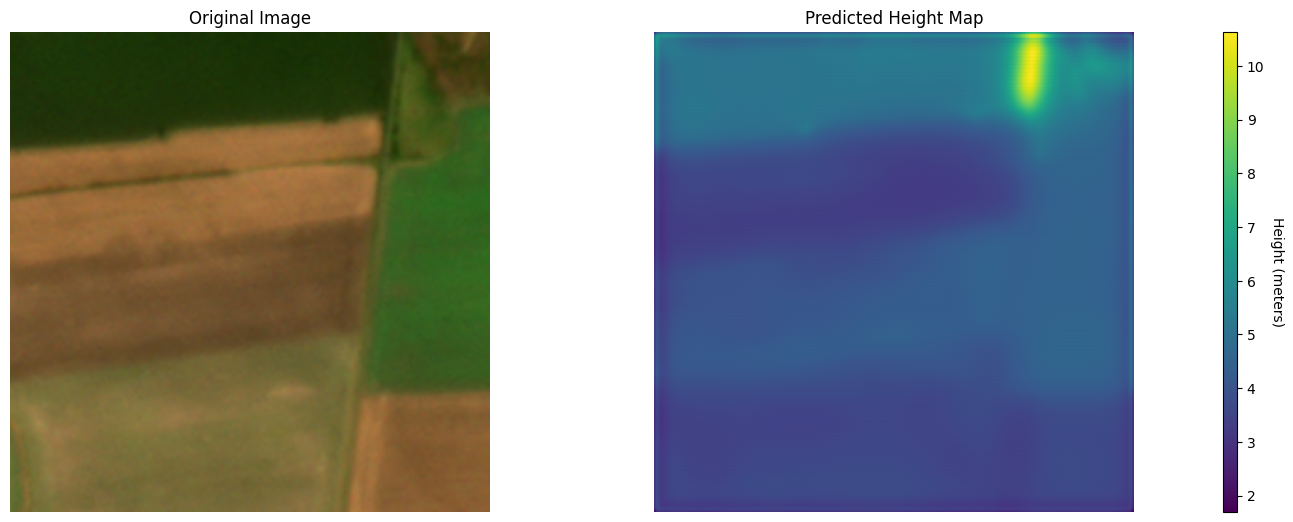

In [8]:
idx = 42
patch = testdata[idx]
img, pred = predict_patch(model, patch, device)
plot_image_and_prediction(img, pred, 3)

In [9]:
image, prediction = predict_image(
    model, device, "data/images/L15-1059E-1348N.tif", patch_size
)

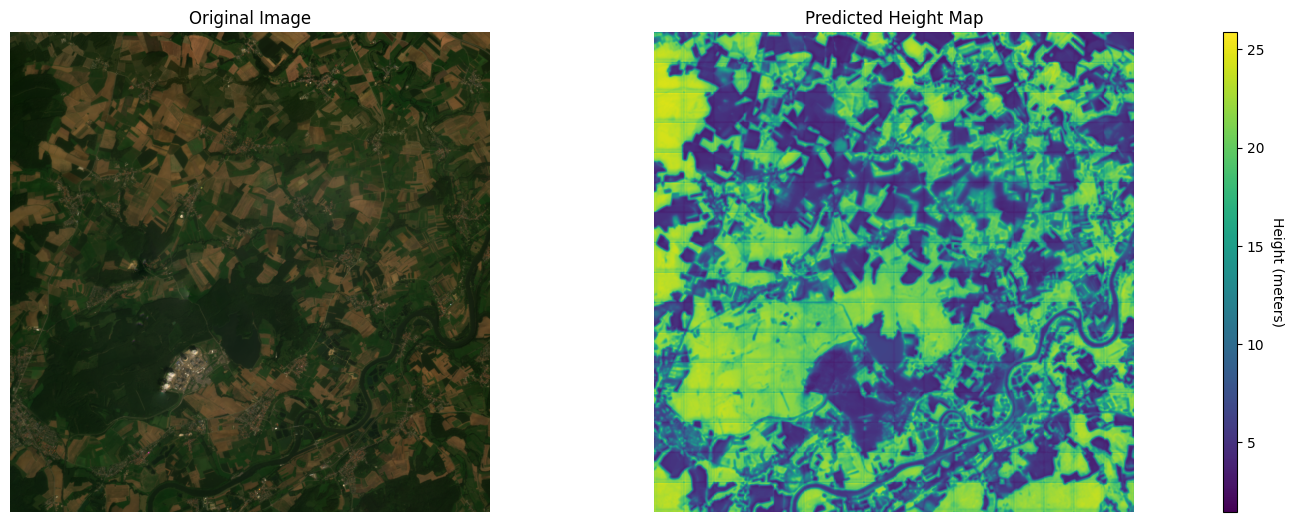

In [10]:
plot_image_and_prediction(image, prediction, 3)

In [11]:
# save_prediction(prediction, os.path.join("results", "L15-1059E-1348N-P.tiff"))